#**VCOMP Assignment 2 - Proposal 3: Classification of defects in photovoltaic modules**

André Soares - up202006516

Daniel Ganicho - up202006518

Diogo Pereira - up202006588

#**Introdução**

A inspeção térmica de módulos fotovoltaicos (PV) é uma técnica não invasiva utilizada para avaliar a saúde e o desempenho de painéis solares. Ao capturar e analisar as assinaturas térmicas emitidas pelos módulos PV, as inspeções térmicas conseguem detetar anomalias, como pontos quentes, acumulação de poeira ou células danificadas. Os pontos quentes, em particular, podem indicar potenciais problemas, como degradação das células ou falhas elétricas. Esta abordagem proativa de manutenção permite a identificação precoce de problemas, reduzindo tempos de inatividade e maximizando a eficiência geral e a vida útil das instalações solares. A inspeção térmica desempenha um papel crucial na garantia da fiabilidade e do rendimento energético dos sistemas PV, tornando-se uma ferramenta essencial no campo da gestão e manutenção de energia solar.

#**Dataset**

O dataset é constituido por 20000 imagens. Cada uma corresponde a uma de 12 classes: cell, cell-multi, cracking, hotspot, hot-spot-multi, shadowing, diode, diode-multi, vegetation, soiling, offline-module
and no-anomaly. O formato das mesmas é em .jpg.

#**Objetivos**



1.   Desenvolver três modelos AI para avaliar o estado do módulo PV usando assinaturas térmicas incluindo: Classificação Binária (Anomalia e Sem Anomalia), Classificação Multiclasse (11 Tipos de Falhas) e Classificação Multiclasse Expandida (11 Tipos de Falhas + Sem Anomalia).
2.   Descrever as técnicas de data augmentation utilizadas.
3.   Comparar os resultados obtidos do modelo AI com um modelo já existente (VGG).
4.   Discutir os resultados obtidos tendo por base o artigo seguinte: https://www.sciencedirect.com/science/article/abs/pii/S0196890424006599




In [ ]:
# Clear directory
!rm -rf /content/sample_data

# Download the zip folder containing the images and the JSON file
!wget -q -O 2020-02-14_InfraredSolarModules.zip https://github.com/RaptorMaps/InfraredSolarModules/raw/master/2020-02-14_InfraredSolarModules.zip

# Unzip folder
!unzip -q 2020-02-14_InfraredSolarModules.zip -d /content/2020-02-14_InfraredSolarModules

# Delete zip folder
!rm 2020-02-14_InfraredSolarModules.zip

# Move the images folder and the JSON file to the top directory
!mv /content/2020-02-14_InfraredSolarModules/InfraredSolarModules/images /content
!mv /content/2020-02-14_InfraredSolarModules/InfraredSolarModules/module_metadata.json /content

# Delete directory after getting all the necessary data
!rm -rf /content/2020-02-14_InfraredSolarModules

!ls /content

images	module_metadata.json


In [ ]:
#Clear source data
#!rm -rf /content/images
#!rm -rf /content/module_metadata.json

In [ ]:
# Imports and setups

import os
import pandas as pd
import json
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight
import torchvision
from torchvision import models, transforms
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.metrics import f1_score, roc_auc_score, balanced_accuracy_score
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

classes_a = ("Anomaly", "No-Anomaly")
classes_b = ("Cell", "Cell-Multi", "Cracking", "Hot-Spot", "Hot-Spot-Multi", "Shadowing", "Diode", "Diode-Multi", "Vegetation", "Soiling", "Offline-Module")
classes_c = ("Cell", "Cell-Multi", "Cracking", "Hot-Spot", "Hot-Spot-Multi", "Shadowing", "Diode", "Diode-Multi", "Vegetation", "Soiling", "Offline-Module", "No-Anomaly")

The model will be running on cuda:0 device


In [ ]:
# show images
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap = 'gray')
  plt.show()

def labelEnconder_A(label):
  dic = {"Anomaly":0, "No-Anomaly":1}
  return dic[label]

def labelEnconder_B(label):
  dic = {"Cell":0, "Cell-Multi":1, "Cracking":2, "Hot-Spot":3, "Hot-Spot-Multi":4, "Shadowing":5, "Diode":6, "Diode-Multi":7, "Vegetation":8, "Soiling":9, "Offline-Module":10}
  return dic[label]

def labelEnconder_C(label):
  dic = {"Cell":0, "Cell-Multi":1, "Cracking":2, "Hot-Spot":3, "Hot-Spot-Multi":4, "Shadowing":5, "Diode":6, "Diode-Multi":7, "Vegetation":8, "Soiling":9, "Offline-Module":10, "No-Anomaly":11}
  return dic[label]

def resize_and_pad_image_transform(image):
  original_image = image

  # Calculate padding dimensions to make the image square
  width, height = original_image.size
  max_dim = max(width, height)
  pad_width = max_dim - width
  pad_height = max_dim - height

  # Create a padding transform
  # padding = transforms.Pad((pad_width // 2, pad_height // 2), fill=(255, 255, 255))   # white padding
  padding = transforms.Pad((pad_width // 2, pad_height // 2), fill=(0, 0, 0))           # dark padding

  # Resize the padded image to the target size
  resize = transforms.Resize((224, 224))
  transform = transforms.Compose([padding, resize])
  resized_image = transform(original_image)

  return resized_image

class myImageDataset_A(data.Dataset):
  def __init__(self, metadata, transform=None, resize_and_RGB=False):
    self.img_labels = metadata["anomaly_class"]
    self.img_path = metadata["image_filepath"]
    self.transform = transform
    self.resize_and_RGB = resize_and_RGB

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    image = read_image(self.img_path[idx])
    label = self.img_labels[idx]

    if self.resize_and_RGB:
      if not isinstance(image, Image.Image):
        image = transforms.ToPILImage()(image)

      image = image.convert("RGB")
      image = resize_and_pad_image_transform(image)
      image = transforms.ToTensor()(image)

    if self.transform:
        image = self.transform(image)

    # Convert the image to a PyTorch tensor and normalize
    label = torch.tensor(labelEnconder_A(label), dtype=torch.long)

    return image, label

  def __getpath__(self, idx):
    return self.img_path[idx]

class myImageDataset_B(data.Dataset):
  def __init__(self, metadata, transform=None, resize_and_RGB=False):
    self.img_labels = metadata["anomaly_class"]
    self.img_path = metadata["image_filepath"]
    self.transform = transform
    self.resize_and_RGB = resize_and_RGB

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    image = read_image(self.img_path[idx])
    label = self.img_labels[idx]

    if self.resize_and_RGB:
      if not isinstance(image, Image.Image):
        image = transforms.ToPILImage()(image)

      image = image.convert("RGB")
      image = resize_and_pad_image_transform(image)
      image = transforms.ToTensor()(image)

    if self.transform:
        image = self.transform(image)

    # Convert the image to a PyTorch tensor and normalize
    label = torch.tensor(labelEnconder_B(label), dtype=torch.long)

    return image, label

  def __getpath__(self, idx):
    return self.img_path[idx]

class myImageDataset_C(data.Dataset):
  def __init__(self, metadata, transform=None, resize_and_RGB=False):
    self.img_labels = metadata["anomaly_class"]
    self.img_path = metadata["image_filepath"]
    self.transform = transform
    self.resize_and_RGB = resize_and_RGB

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    image = read_image(self.img_path[idx])
    label = self.img_labels[idx]

    if self.resize_and_RGB:
      if not isinstance(image, Image.Image):
        image = transforms.ToPILImage()(image)

      image = image.convert("RGB")
      image = resize_and_pad_image_transform(image)
      image = transforms.ToTensor()(image)

    if self.transform:
        image = self.transform(image)

    # Convert the image to a PyTorch tensor and normalize
    label = torch.tensor(labelEnconder_C(label), dtype=torch.long)

    return image, label

  def __getpath__(self, idx):
    return self.img_path[idx]

In [ ]:
#------------------------------ Dataset Loading and Creation of DataLoader ------------------------------

#Load metadata
metadata_path = '/content/module_metadata.json'
with open(metadata_path, 'r') as f:
  metadata = json.load(f)

metadata_A = copy.deepcopy(metadata)
metadata_B = copy.deepcopy(metadata)
metadata_C = copy.deepcopy(metadata)
metadata_VGG = copy.deepcopy(metadata)

# Preparation of data for A
for key, value in metadata_A.items():
  if value["anomaly_class"] != 'No-Anomaly':
    value["anomaly_class"] = 'Anomaly'

# Preparation of data for B
for key in list(metadata_B.keys()):
    if metadata_B[key]["anomaly_class"] == 'No-Anomaly':
        del metadata_B[key]

# Convert metadata to a DataFrame
metadata_df_A = pd.DataFrame.from_dict(metadata_A, orient='index')
metadata_df_B = pd.DataFrame.from_dict(metadata_B, orient='index')
metadata_df_C = pd.DataFrame.from_dict(metadata_C, orient='index')
metadata_df_VGG = pd.DataFrame.from_dict(metadata_VGG, orient='index')

train_metadata_A, test_metadata_A = train_test_split(metadata_df_A, test_size = 0.2, random_state = 42, stratify = metadata_df_A["anomaly_class"])
train_metadata_A.reset_index(drop=True, inplace=True)
test_metadata_A.reset_index(drop=True, inplace=True)

train_metadata_B, test_metadata_B = train_test_split(metadata_df_B, test_size = 0.2, random_state = 42, stratify = metadata_df_B["anomaly_class"])
train_metadata_B.reset_index(drop=True, inplace=True)
test_metadata_B.reset_index(drop=True, inplace=True)

train_metadata_C, test_metadata_C = train_test_split(metadata_df_C, test_size = 0.2, random_state = 42, stratify = metadata_df_C["anomaly_class"])
train_metadata_C.reset_index(drop=True, inplace=True)
test_metadata_C.reset_index(drop=True, inplace=True)

train_metadata_VGG, test_metadata_VGG = train_test_split(metadata_df_VGG, test_size = 0.2, random_state = 42, stratify = metadata_df_C["anomaly_class"])
train_metadata_VGG.reset_index(drop=True, inplace=True)
test_metadata_VGG.reset_index(drop=True, inplace=True)

In [ ]:
# ----------------------------------------------- Augmentation -----------------------------------------------
# Selective Augmentation
augmentation_dict_A = {"Anomaly":1, "No-Anomaly":1}
augmentation_dict_B = {"Cell":5, "Cell-Multi":7, "Cracking":10, "Hot-Spot":40, "Hot-Spot-Multi":40, "Shadowing":9, "Diode":6, "Diode-Multi":57, "Vegetation":5, "Soiling":50, "Offline-Module":12}
augmentation_dict_C = {"Cell":5, "Cell-Multi":7, "Cracking":10, "Hot-Spot":40, "Hot-Spot-Multi":40, "Shadowing":9, "Diode":6, "Diode-Multi":57, "Vegetation":5, "Soiling":50, "Offline-Module":12, "No-Anomaly":0}

augmentation = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.RandomVerticalFlip(p=0.5),
                                  transforms.RandomPerspective(distortion_scale=0.2, p=0.2, interpolation=Image.NEAREST),
                                  transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                  transforms.RandomAffine(degrees=6, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                                  ])

# List to store augmented DataFrames
augmented_dfs_A = []
for to_augment_class, n in augmentation_dict_A.items():
  for i in range(0, n):
    for index, metadata in train_metadata_A.iterrows():
      if metadata["anomaly_class"] == to_augment_class:
        image = read_image(metadata["image_filepath"])
        augmented_img = augmentation(image)
        augmented_path = os.path.join("images/", str(index) + f"_augmented_A_" + str(i) + f".jpg")
        augmented_img.save(augmented_path)
        to_append = pd.DataFrame({"image_filepath": [augmented_path], "anomaly_class": [metadata["anomaly_class"]]})
        augmented_dfs_A.append(to_append)

augmented_dfs_B = []
for to_augment_class, n in augmentation_dict_B.items():
  for i in range(0, n):
    for index, metadata in train_metadata_B.iterrows():
      if metadata["anomaly_class"] == to_augment_class:
        image = read_image(metadata["image_filepath"])
        augmented_img = augmentation(image)
        augmented_path = os.path.join("images/", str(index) + f"_augmented_B_" + str(i) + f".jpg")
        augmented_img.save(augmented_path)
        to_append = pd.DataFrame({"image_filepath": [augmented_path], "anomaly_class": [metadata["anomaly_class"]]})
        augmented_dfs_B.append(to_append)

augmented_dfs_C = []
for to_augment_class, n in augmentation_dict_C.items():
  for i in range(0, n):
    for index, metadata in train_metadata_C.iterrows():
      if metadata["anomaly_class"] == to_augment_class:
        image = read_image(metadata["image_filepath"])
        augmented_img = augmentation(image)
        augmented_path = os.path.join("images/", str(index) + f"_augmented_C_" + str(i) + f".jpg")
        augmented_img.save(augmented_path)
        to_append = pd.DataFrame({"image_filepath": [augmented_path], "anomaly_class": [metadata["anomaly_class"]]})
        augmented_dfs_C.append(to_append)

# Concatenate all augmented DataFrames into one
augmented_df_A = pd.concat(augmented_dfs_A, ignore_index=True)
augmented_df_B = pd.concat(augmented_dfs_B, ignore_index=True)
augmented_df_C = pd.concat(augmented_dfs_C, ignore_index=True)

# Reset the index of metadata_df and augmented_df
train_metadata_A.reset_index(drop=True, inplace=True)
train_metadata_B.reset_index(drop=True, inplace=True)
train_metadata_C.reset_index(drop=True, inplace=True)

augmented_df_A.reset_index(drop=True, inplace=True)
augmented_df_B.reset_index(drop=True, inplace=True)
augmented_df_C.reset_index(drop=True, inplace=True)

# Update the original train_metadata with the augmented data
train_metadata_A = pd.concat([train_metadata_A, augmented_df_A], ignore_index=True)
train_metadata_B = pd.concat([train_metadata_B, augmented_df_B], ignore_index=True)
train_metadata_C = pd.concat([train_metadata_C, augmented_df_C], ignore_index=True)

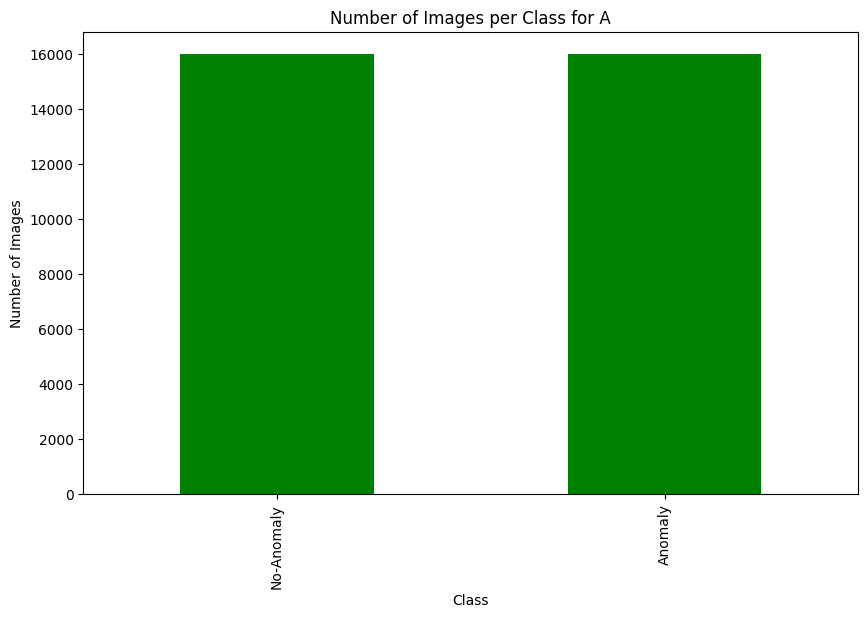

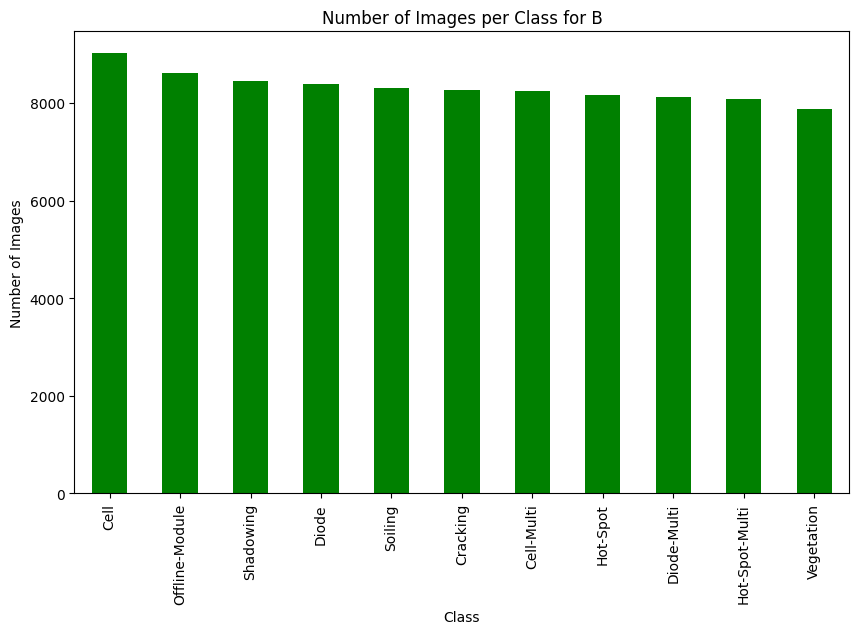

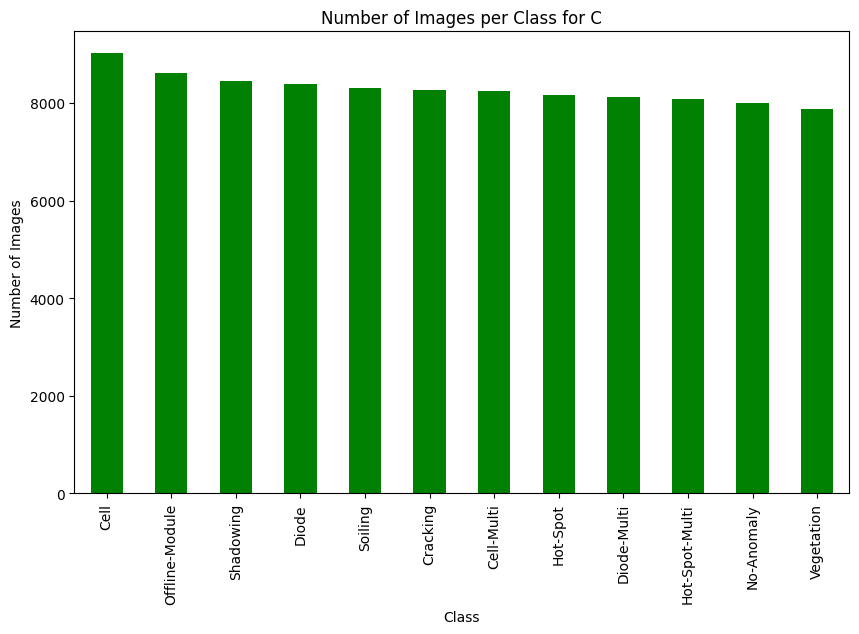

In [ ]:
# Show Image Distribution per class
class_counts_A = train_metadata_A['anomaly_class'].value_counts()
class_counts_B = train_metadata_B['anomaly_class'].value_counts()
class_counts_C = train_metadata_C['anomaly_class'].value_counts()


# Plotting the bar graph
plt.figure(figsize=(10, 6))
class_counts_A.plot(kind='bar', color='green')
plt.title('Number of Images per Class for A')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

plt.figure(figsize=(10, 6))
class_counts_B.plot(kind='bar', color='green')
plt.title('Number of Images per Class for B')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

plt.figure(figsize=(10, 6))
class_counts_C.plot(kind='bar', color='green')
plt.title('Number of Images per Class for C')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

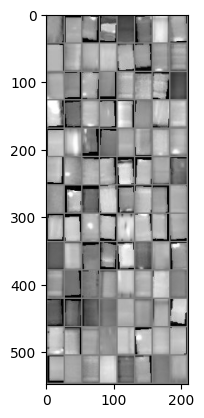

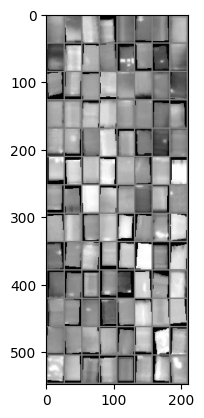

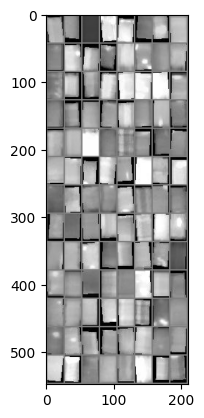

In [ ]:
# Dataloader Creation

# Define the transforms
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.ToTensor(),
                                transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
                                transforms.Normalize(mean=[0.5], std=[0.5])])

datasetTrain_A = myImageDataset_A(train_metadata_A, transform = transform)
datasetTest_A = myImageDataset_A(test_metadata_A, transform = transform)

datasetTrain_B = myImageDataset_B(train_metadata_B, transform = transform)
datasetTest_B = myImageDataset_B(test_metadata_B, transform = transform)

datasetTrain_C = myImageDataset_C(train_metadata_C, transform = transform)
datasetTest_C = myImageDataset_C(test_metadata_C, transform = transform)

# Dataloaders linked to datasets
batch_size = 200

trainloader_A = torch.utils.data.DataLoader(datasetTrain_A, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_A = torch.utils.data.DataLoader(datasetTest_A, batch_size=batch_size, shuffle=False, num_workers=2)

trainloader_B = torch.utils.data.DataLoader(datasetTrain_B, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_B = torch.utils.data.DataLoader(datasetTest_B, batch_size=batch_size, shuffle=False, num_workers=2)

trainloader_C = torch.utils.data.DataLoader(datasetTrain_C, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_C = torch.utils.data.DataLoader(datasetTest_C, batch_size=batch_size, shuffle=False, num_workers=2)

# get some random training images
images_A, labels_A = next(iter(trainloader_A))
images_B, labels_B = next(iter(trainloader_B))
images_C, labels_C = next(iter(trainloader_C))

imshow(torchvision.utils.make_grid(images_A[:104]))
imshow(torchvision.utils.make_grid(images_B[:104]))
imshow(torchvision.utils.make_grid(images_C[:104]))

In [ ]:
# Plot Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_predictions(model, iterator, device, binary_classification=False):
    model.eval()
    images = []
    labels = []
    probs = []
    pred_labels = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred  = model(x)

            if binary_classification:
              y_prob = torch.sigmoid(y_pred)
              pred_label = torch.round(y_prob)
              y_prob = torch.cat((y_prob.cpu(), 1 - y_prob.cpu()), dim=1)
            else:
              y_prob = F.softmax(y_pred, dim=-1)
              pred_label = torch.argmax(y_prob, dim=1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
            pred_labels.append(pred_label.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)
    pred_labels = torch.cat(pred_labels, dim=0).squeeze()

    return images, labels, probs, pred_labels

def plot_confusion_matrix(labels, pred_labels, model_index):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)

    if model_index == 'A':
      cm = ConfusionMatrixDisplay(confusion_matrix = cm.astype(int), display_labels = classes_a)
    elif model_index == 'B':
      cm = ConfusionMatrixDisplay(confusion_matrix = cm.astype(int), display_labels = classes_b)
    elif model_index == 'C':
      cm = ConfusionMatrixDisplay(confusion_matrix = cm.astype(int), display_labels = classes_c)
    elif model_index == 'VGG11':
      cm = ConfusionMatrixDisplay(confusion_matrix = cm.astype(int), display_labels = classes_c)
    elif model_index == 'VGG16':
      cm = ConfusionMatrixDisplay(confusion_matrix = cm.astype(int), display_labels = classes_c)

    cm.plot(values_format='d', cmap='Blues', ax=ax, xticks_rotation=90)

In [ ]:
# Train Function

# Function to save the model
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_epochs,
          path_model,
          verbatim,
          scheduler):

  train_loss_min = np.Inf

  for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc_sample = 0.0
    train_f1 = 0.0

    train_pred, train_labels = [], []

    model.train()

    for ibatch, (images, labels) in enumerate(dataloader, 0):
      # get the inputs
      images = images.to(device)
      labels = labels.to(device)

      # forward pass
      y_pred = model(images)

      # calculate and accumulate loss
      if isinstance(loss_fn, torch.nn.BCEWithLogitsLoss):
        loss = loss_fn(y_pred.view(-1), labels.float())
      elif isinstance(loss_fn, torch.nn.CrossEntropyLoss):
        loss = loss_fn(y_pred, labels)
      train_loss += loss.item()

      # optimizer zero grad
      optimizer.zero_grad()

      # loss backward
      loss.backward()

      # optimizer step
      optimizer.step()

      # scheduler step
      scheduler.step()

      # track train loss by multiplying average loss by number of examples in batch
      train_loss += loss.item() * images.size(0)

      # calculate accuracy by finding max log probability
      if isinstance(loss_fn, torch.nn.BCEWithLogitsLoss):
        pred = (torch.sigmoid(y_pred) >= 0.5).long()
      elif isinstance(loss_fn, torch.nn.CrossEntropyLoss):
        _, pred = torch.max(y_pred, dim=1)

      correct_tensor = pred.eq(labels.data.view_as(pred))

      # need to convert correct tensor from int to float to average
      accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

      # multiply average accuracy times number of examples in batch
      train_acc_sample += accuracy.item() * images.size(0)

      train_pred.append(pred.cpu().numpy())
      train_labels.append(labels.cpu().numpy())

    # calculate average losses
    train_loss = train_loss / len(dataloader.dataset)

    # calculate average accuracy
    train_acc_sample = train_acc_sample / len(dataloader.dataset)

    # calculate average F1-score
    train_pred = np.concatenate(train_pred, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    train_f1 = f1_score(train_labels, train_pred, average='weighted')

    train_acc_class = balanced_accuracy_score(train_labels, train_pred)

    # print training results
    if verbatim:
      print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f}')
      print(f'\t\tTraining Accuracy (Sample): {train_acc_sample*100:.2f}%')
      print(f'\t\tTraining Accuracy (Class): {train_acc_class*100:.2f}%')
      print(f'\t\tTraining F1-score (Weighted): {train_f1*100:.2f}%')

    # save model if validation loss decreases
    if train_loss < train_loss_min:
      # save model
      path = str(path_model)
      saveModel(model, path=path)

      # track improvement
      train_loss_min = train_loss
      train_best_acc_sample = train_acc_sample
      train_best_acc_class = train_acc_class
      train_best_f1 = train_f1
      best_epoch = epoch

  # load the best state dict
  model.load_state_dict(torch.load(path))

  # attach the optimizer
  model.optimizer = optimizer

  return train_loss_min, train_best_acc_sample, train_best_acc_class, best_epoch

In [ ]:
# Test Function

def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim = True):

  # put model in eval mode
  model.eval()

  # setup test loss and test accuracy values
  test_loss, test_acc_sample, test_f1 = 0.0, 0.0, 0.0
  pred_labels, true_labels = [], []

  with torch.no_grad():
    for data in dataloader:
      # get the inputs
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)

      # run the model on the test set to predict labels
      y_pred = model(images)

      # calculate and accumulate loss
      if isinstance(loss_fn, torch.nn.BCEWithLogitsLoss):
        loss = loss_fn(y_pred.view(-1), labels.float())
      elif isinstance(loss_fn, torch.nn.CrossEntropyLoss):
        loss = loss_fn(y_pred, labels)

      test_loss += loss.item()

      # calculate and accumulate accuracy
      if isinstance(loss_fn, torch.nn.BCEWithLogitsLoss):
        y_pred_class = (torch.sigmoid(y_pred) >= 0.5).long().squeeze()
      elif isinstance(loss_fn, torch.nn.CrossEntropyLoss):
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

      test_acc_sample += (y_pred_class == labels).sum().item() / len(labels)
      pred_labels.extend(y_pred_class.tolist())
      true_labels.extend(labels.tolist())

  # adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc_sample = test_acc_sample / len(dataloader)

  # calculate F1-score
  test_f1 = f1_score(true_labels, pred_labels, average='weighted')

  # calculate average accuracy
  test_acc_class = balanced_accuracy_score(true_labels, pred_labels)

  if verbatim:
    print(f'Loss = {test_loss:.4f} | Accuracy (Sample) = {test_acc_sample*100:.2f}% | Accuracy (Class) = {test_acc_class*100:.2f}% | F1-score (Weighted) = {test_f1*100:.2f}%')

  return pred_labels, test_loss, test_acc_sample, test_acc_class, test_f1

# **MODEL A**

In [ ]:
# Define Network for A

# Imagem Original: 24x40px

class Network_A(nn.Module):
  def __init__(self):
    super(Network_A, self).__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_block_4 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))

    self.fc_block = nn.Sequential(
        nn.Linear(512 * 1 * 1, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 1)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.conv_block_3(x)
    x = self.conv_block_4(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc_block(x)

    return x


model_A = Network_A().to(device)
summary(model_A, input_size=(1, 40, 24))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 40, 24]             640
       BatchNorm2d-2           [-1, 64, 40, 24]             128
              ReLU-3           [-1, 64, 40, 24]               0
         MaxPool2d-4           [-1, 64, 20, 12]               0
            Conv2d-5          [-1, 128, 20, 12]          73,856
       BatchNorm2d-6          [-1, 128, 20, 12]             256
              ReLU-7          [-1, 128, 20, 12]               0
         MaxPool2d-8           [-1, 128, 10, 6]               0
            Conv2d-9           [-1, 256, 10, 6]         295,168
      BatchNorm2d-10           [-1, 256, 10, 6]             512
             ReLU-11           [-1, 256, 10, 6]               0
        MaxPool2d-12            [-1, 256, 5, 3]               0
           Conv2d-13            [-1, 512, 5, 3]       1,180,160
      BatchNorm2d-14            [-1, 51

In [ ]:
# Train Model A
print('Train Phase for Model A:')

model_A = model_A.to(device)
weight_A = torch.tensor([0.25])
loss_fn_A = nn.BCEWithLogitsLoss(weight=weight_A).to(device)
optimizer_A = Adam(model_A.parameters(), lr=0.001)
scheduler_A = lr_scheduler.LinearLR(optimizer_A, start_factor=1.0, end_factor=0.3, total_iters=len(trainloader_A)*10)

# Create folder if it doesn't exist
folder_path_A = "/content/model_a"

model_path_A = "/content/model_a/myModel_A.pth"

if not os.path.exists(folder_path_A):
  os.makedirs(folder_path_A)

# Build model
best_loss_A, best_accuracy_sample_A, best_accuracy_class_A, best_epoch_A = train(model=model_A,
                                                                                dataloader=trainloader_A,
                                                                                loss_fn=loss_fn_A,
                                                                                optimizer=optimizer_A,
                                                                                device=device,
                                                                                num_epochs=40,
                                                                                path_model=model_path_A,
                                                                                verbatim=True,
                                                                                scheduler=scheduler_A)

print("Finished Training")

Train Phase for Model A:

Epoch: 0 	Training Loss: 0.1274
		Training Accuracy (Sample): 74.52%
		Training Accuracy (Class): 74.52%
		Training F1-score (Weighted): 74.41%

Epoch: 1 	Training Loss: 0.1016
		Training Accuracy (Sample): 81.92%
		Training Accuracy (Class): 81.92%
		Training F1-score (Weighted): 81.80%

Epoch: 2 	Training Loss: 0.0925
		Training Accuracy (Sample): 83.93%
		Training Accuracy (Class): 83.93%
		Training F1-score (Weighted): 83.86%

Epoch: 3 	Training Loss: 0.0882
		Training Accuracy (Sample): 84.71%
		Training Accuracy (Class): 84.71%
		Training F1-score (Weighted): 84.66%

Epoch: 4 	Training Loss: 0.0804
		Training Accuracy (Sample): 86.29%
		Training Accuracy (Class): 86.29%
		Training F1-score (Weighted): 86.26%

Epoch: 5 	Training Loss: 0.0756
		Training Accuracy (Sample): 87.47%
		Training Accuracy (Class): 87.48%
		Training F1-score (Weighted): 87.45%

Epoch: 6 	Training Loss: 0.0714
		Training Accuracy (Sample): 88.21%
		Training Accuracy (Class): 88.21%

<ipython-input-10-b11644e1a580>:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<ipython-input-14-39c5365d458c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_A.load_state_dict(torch.load(str(model_path_A)))


Loss = 0.0740 | Accuracy (Sample) = 93.88% | Accuracy (Class) = 93.88% | F1-score (Weighted) = 93.87%


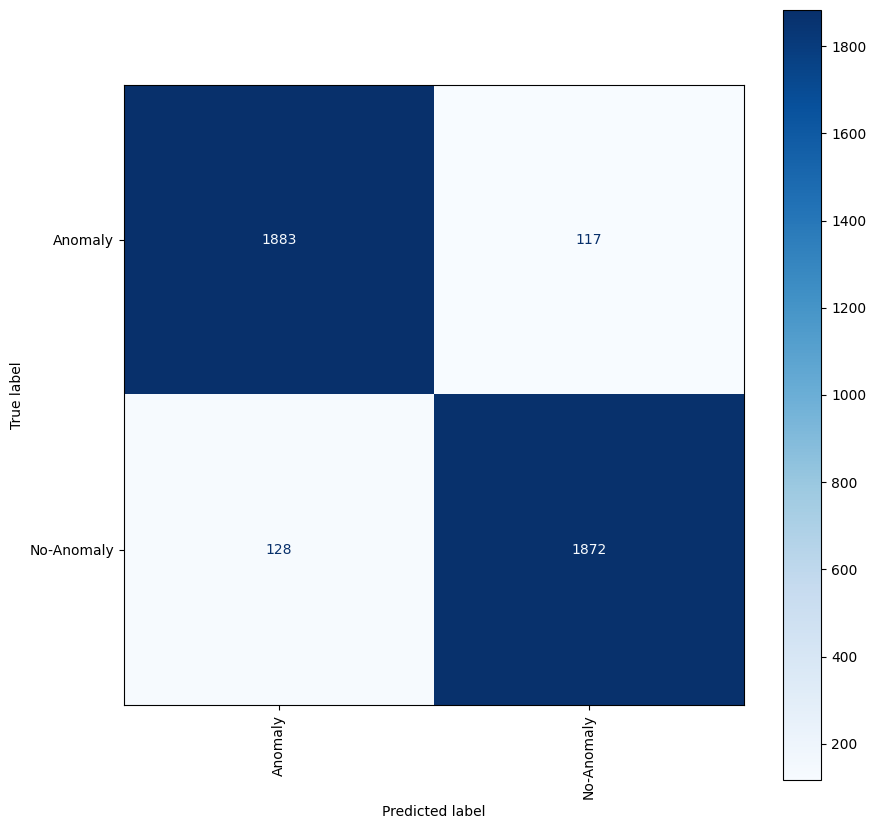

In [ ]:
# Test Model A
model_A = Network_A().to(device)
model_A.load_state_dict(torch.load(str(model_path_A)))

weight_A = torch.tensor([0.25])
loss_fn_A = nn.BCEWithLogitsLoss(weight=weight_A).to(device)

y_pred_A, test_loss_A, test_acc_sample_A, test_acc_class_A, test_f1_A = test(model=model_A,
                                                                   dataloader=testloader_A,
                                                                   loss_fn=loss_fn_A,
                                                                   device=device,
                                                                   verbatim=True)
images_A, labels_A, probs_A, pred_labels_A = get_predictions(model_A, testloader_A, device, binary_classification=True)

plot_confusion_matrix(labels_A, pred_labels_A, 'A')


# **MODEL B**

In [ ]:
# Define Network for B

class Network_B(nn.Module):
  def __init__(self):
    super(Network_B, self).__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_block3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_block4 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    self.fc_block = nn.Sequential(
        nn.Linear(512 * 1 * 1, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 11)
    )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.conv_block3(x)
    x = self.conv_block4(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc_block(x)

    return x

model_B = Network_B().to(device)
summary(model_B, input_size=(1, 40, 24))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 40, 24]             640
       BatchNorm2d-2           [-1, 64, 40, 24]             128
              ReLU-3           [-1, 64, 40, 24]               0
         MaxPool2d-4           [-1, 64, 20, 12]               0
            Conv2d-5          [-1, 128, 20, 12]          73,856
       BatchNorm2d-6          [-1, 128, 20, 12]             256
              ReLU-7          [-1, 128, 20, 12]               0
         MaxPool2d-8           [-1, 128, 10, 6]               0
            Conv2d-9           [-1, 256, 10, 6]         295,168
      BatchNorm2d-10           [-1, 256, 10, 6]             512
             ReLU-11           [-1, 256, 10, 6]               0
        MaxPool2d-12            [-1, 256, 5, 3]               0
           Conv2d-13            [-1, 512, 5, 3]       1,180,160
      BatchNorm2d-14            [-1, 51

In [ ]:
# Train Model B
print('Train Phase for Model B:')

model_B = model_B.to(device)
anomaly_classes_B = train_metadata_B["anomaly_class"]
class_weight_compute_B = compute_class_weight('balanced', classes=np.array(classes_b), y=anomaly_classes_B)
weights_B = torch.tensor(class_weight_compute_B, dtype=torch.float32)
loss_fn_B = nn.CrossEntropyLoss(weight=weights_B).to(device)
optimizer_B = Adam(model_B.parameters(), lr=0.001)
scheduler_B = lr_scheduler.LinearLR(optimizer_B, start_factor=1.0, end_factor=0.3, total_iters=len(trainloader_B)*10)

# Create folder if it doesn't exist
folder_path_B = "/content/model_b"

model_path_B = "/content/model_b/myModel_B.pth"

if not os.path.exists(folder_path_B):
  os.makedirs(folder_path_B)

# Build model
best_loss_B, best_accuracy_sample_B, best_accuracy_class_B, best_epoch_B = train(model=model_B,
                                                                                dataloader=trainloader_B,
                                                                                loss_fn=loss_fn_B,
                                                                                optimizer=optimizer_B,
                                                                                device=device,
                                                                                num_epochs=40,
                                                                                path_model=model_path_B,
                                                                                verbatim=True,
                                                                                scheduler=scheduler_B)

print("Finished Training")

Train Phase for Model B:

Epoch: 0 	Training Loss: 1.6332
		Training Accuracy (Sample): 43.02%
		Training Accuracy (Class): 43.13%
		Training F1-score (Weighted): 42.21%

Epoch: 1 	Training Loss: 1.1325
		Training Accuracy (Sample): 60.10%
		Training Accuracy (Class): 60.19%
		Training F1-score (Weighted): 59.47%

Epoch: 2 	Training Loss: 0.9569
		Training Accuracy (Sample): 66.12%
		Training Accuracy (Class): 66.21%
		Training F1-score (Weighted): 65.67%

Epoch: 3 	Training Loss: 0.8394
		Training Accuracy (Sample): 70.15%
		Training Accuracy (Class): 70.23%
		Training F1-score (Weighted): 69.75%

Epoch: 4 	Training Loss: 0.7374
		Training Accuracy (Sample): 73.72%
		Training Accuracy (Class): 73.81%
		Training F1-score (Weighted): 73.38%

Epoch: 5 	Training Loss: 0.6465
		Training Accuracy (Sample): 77.05%
		Training Accuracy (Class): 77.14%
		Training F1-score (Weighted): 76.76%

Epoch: 6 	Training Loss: 0.5648
		Training Accuracy (Sample): 79.82%
		Training Accuracy (Class): 79.91%

<ipython-input-10-b11644e1a580>:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<ipython-input-17-8d9ba352efa9>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_B.load_state_dict(torch.load(str(model_path_B)))


Loss = 2.0076 | Accuracy (Sample) = 72.95% | Accuracy (Class) = 69.22% | F1-score (Weighted) = 72.87%


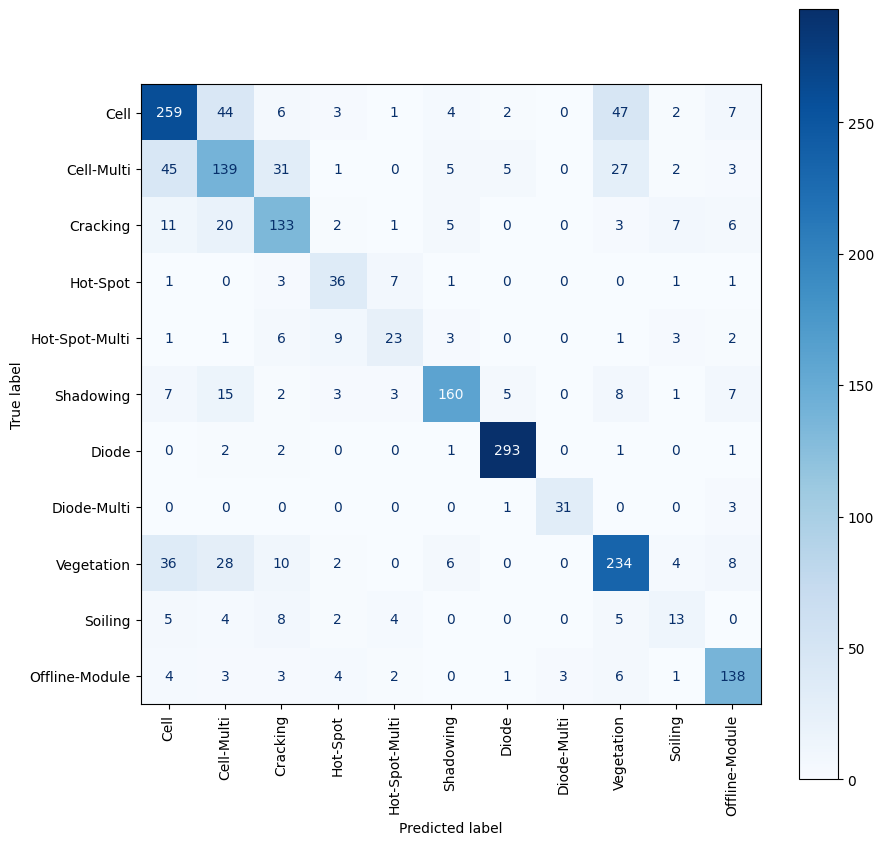

In [ ]:
# Test Model B
model_B = Network_B().to(device)
model_B.load_state_dict(torch.load(str(model_path_B)))

anomaly_classes_B = train_metadata_B["anomaly_class"]
class_weight_compute_B = compute_class_weight('balanced', classes=np.array(classes_b), y=anomaly_classes_B)
weights_B = torch.tensor(class_weight_compute_B, dtype=torch.float32)
loss_fn_B = nn.CrossEntropyLoss(weight=weights_B).to(device)

y_pred_B, test_loss_B, test_acc_sample_B, test_acc_class_B, test_f1_B = test(model=model_B,
                                                                            dataloader=testloader_B,
                                                                            loss_fn=loss_fn_B,
                                                                            device=device,
                                                                            verbatim=True)
images_B, labels_B, probs_B, pred_labels_B = get_predictions(model_B, testloader_B, device, binary_classification=False)

plot_confusion_matrix(labels_B, pred_labels_B, 'B')

#**MODEL C**

In [ ]:
# Define Network for C

class Network_C(nn.Module):
  def __init__(self):
    super(Network_C, self).__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_block3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_block4 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    self.fc_block = nn.Sequential(
        nn.Linear(512 * 1 * 1, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 12)
    )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.conv_block3(x)
    x = self.conv_block4(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc_block(x)

    return x

model_C = Network_C().to(device)
summary(model_C, input_size=(1, 40, 24))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 40, 24]             640
       BatchNorm2d-2           [-1, 64, 40, 24]             128
              ReLU-3           [-1, 64, 40, 24]               0
         MaxPool2d-4           [-1, 64, 20, 12]               0
            Conv2d-5          [-1, 128, 20, 12]          73,856
       BatchNorm2d-6          [-1, 128, 20, 12]             256
              ReLU-7          [-1, 128, 20, 12]               0
         MaxPool2d-8           [-1, 128, 10, 6]               0
            Conv2d-9           [-1, 256, 10, 6]         295,168
      BatchNorm2d-10           [-1, 256, 10, 6]             512
             ReLU-11           [-1, 256, 10, 6]               0
        MaxPool2d-12            [-1, 256, 5, 3]               0
           Conv2d-13            [-1, 512, 5, 3]       1,180,160
      BatchNorm2d-14            [-1, 51

In [ ]:
# Train Model C
print('Train Phase for Model C:')

model_C = model_C.to(device)
anomaly_classes_C = train_metadata_C["anomaly_class"]
class_weight_compute_C = compute_class_weight('balanced', classes=np.array(classes_c), y=anomaly_classes_C)
weights_C = torch.tensor(class_weight_compute_C, dtype=torch.float32)
loss_fn_C = nn.CrossEntropyLoss(weight=weights_C).to(device)
optimizer_C = Adam(model_C.parameters(), lr=0.001)
scheduler_C = lr_scheduler.LinearLR(optimizer_C, start_factor=1.0, end_factor=0.3, total_iters=len(trainloader_C)*10)

# Create folder if it doesn't exist
folder_path_C = "/content/model_c"

model_path_C = "/content/model_c/myModel_C.pth"

if not os.path.exists(folder_path_C):
  os.makedirs(folder_path_C)

# Build model
best_loss_C, best_accuracy_sample_C, best_accuracy_class_C, best_epoch_C = train(model=model_C,
                                                                                dataloader=trainloader_C,
                                                                                loss_fn=loss_fn_C,
                                                                                optimizer=optimizer_C,
                                                                                device=device,
                                                                                num_epochs=40,
                                                                                path_model=model_path_C,
                                                                                verbatim=True,
                                                                                scheduler=scheduler_C)

print("Finished Training")

Train Phase for Model C:

Epoch: 0 	Training Loss: 1.5721
		Training Accuracy (Sample): 45.75%
		Training Accuracy (Class): 46.01%
		Training F1-score (Weighted): 44.33%

Epoch: 1 	Training Loss: 1.1135
		Training Accuracy (Sample): 61.23%
		Training Accuracy (Class): 61.44%
		Training F1-score (Weighted): 60.46%

Epoch: 2 	Training Loss: 0.9404
		Training Accuracy (Sample): 66.90%
		Training Accuracy (Class): 67.09%
		Training F1-score (Weighted): 66.38%

Epoch: 3 	Training Loss: 0.8156
		Training Accuracy (Sample): 71.29%
		Training Accuracy (Class): 71.46%
		Training F1-score (Weighted): 70.87%

Epoch: 4 	Training Loss: 0.7123
		Training Accuracy (Sample): 74.89%
		Training Accuracy (Class): 75.05%
		Training F1-score (Weighted): 74.55%

Epoch: 5 	Training Loss: 0.6228
		Training Accuracy (Sample): 77.90%
		Training Accuracy (Class): 78.06%
		Training F1-score (Weighted): 77.62%

Epoch: 6 	Training Loss: 0.5311
		Training Accuracy (Sample): 81.22%
		Training Accuracy (Class): 81.36%

<ipython-input-10-b11644e1a580>:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<ipython-input-20-521c5c810462>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_C.load_state_dict(torch.load(str(model_path_C)))


Loss = 1.3562 | Accuracy (Sample) = 81.73% | Accuracy (Class) = 67.35% | F1-score (Weighted) = 81.37%


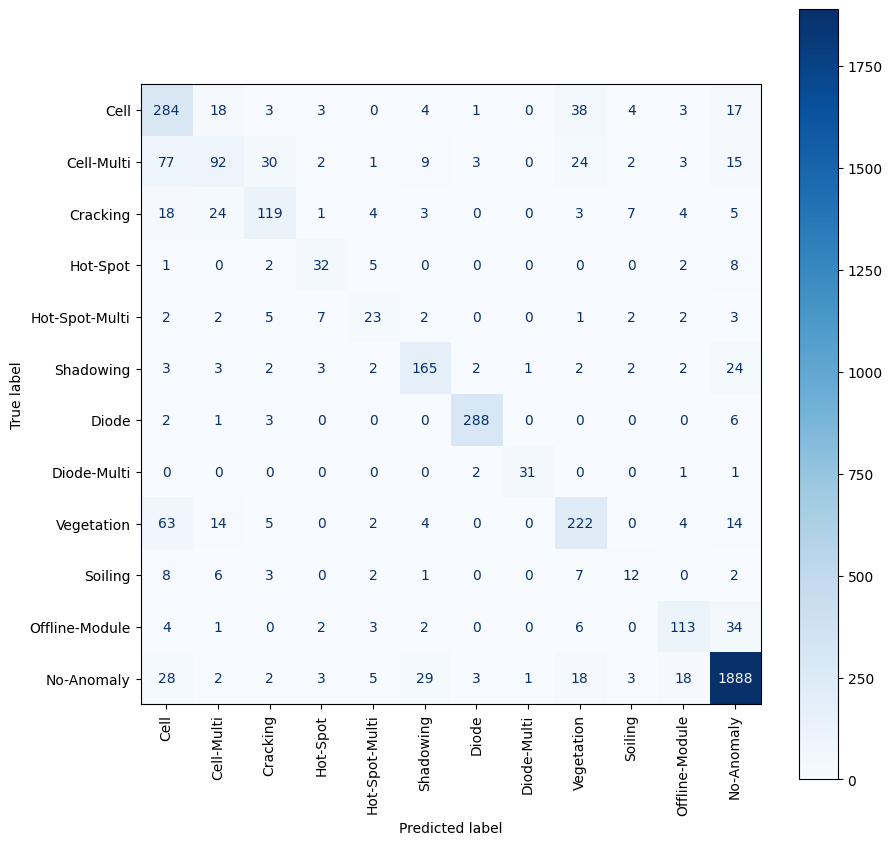

In [ ]:
# Test Model C
model_C = Network_C().to(device)
model_C.load_state_dict(torch.load(str(model_path_C)))

anomaly_classes_C = train_metadata_C["anomaly_class"]
class_weight_compute_C = compute_class_weight('balanced', classes=np.array(classes_c), y=anomaly_classes_C)
weights_C = torch.tensor(class_weight_compute_C, dtype=torch.float32)
loss_fn_C = nn.CrossEntropyLoss(weight=weights_C).to(device)

y_pred_C, test_loss_C, test_acc_sample_C, test_acc_class_C, test_f1_C = test(model=model_C,
                                                                            dataloader=testloader_C,
                                                                            loss_fn=loss_fn_C,
                                                                            device=device,
                                                                            verbatim=True)
images_C, labels_C, probs_C, pred_labels_C = get_predictions(model_C, testloader_C, device, binary_classification=False)

plot_confusion_matrix(labels_C, pred_labels_C, 'C')

#**2) Description of the data augmentation technique**

Dado o reduzido número de amostras em algumas classes, foi necessário recorrer a técnicas de aumento de dados para treino dos modelos. Assim, foram aplicadas as seguintes transformações:



*   **Horizontal Flip:** Simula a aparência de objetos que poderiam ser vistos de forma espelhada.

*   **Vertical Flip:** Embora inversões verticais sejam menos comuns em visão por computador (dependendo do contexto do problema), isso pode ser útil para aumentar a variedade de dados em cenários específicos.

*  **Random Perspective:** Simula mudanças na posição relativa da câmera ou deformações, tornando o modelo mais robusto a perspectivas diferentes.

*  **Random Affine:** Simula variações reais na posição, orientação e escala dos objetos na imagem.

*  **Color Jitter:** Simula condições de iluminação diferentes, como mudanças na intensidade da luz do dia ou sombras.

Deste modo, as técnicas descritas acima foram aplicadas com os seguintes parâmetros:

* **Horizontal Flip (50%):** Aplica uma inversão horizontal aleatória na imagem com uma probabilidade de 50%.

* **Vertical Flip (50%):** Aplica uma inversão vertical aleatória na imagem com uma probabilidade de 50%.

* **Random Perspective:** Aplica uma transformação de perspectiva aleatória com um grau de distorção controlado de 0.2 e uma probabilidade de 20%.

* **Random Affine ((-6º,+6º),(-10%,+10%),(0.9,1.1)):** Aplica transformações afins aleatórias, que incluem variações de rotações entre -6º e +6º em torno do centro da imagem, translações horizontais e verticais de até 10% da dimensão da imagem, e variações no tamanho entre 90% e 110% da escala original.

* **Color Jitter (20%,20%):** Altera aleatoriamente o brilho e o contraste da imagem em até +/- 20% cada.



# **3) Comparison with AI-model VGG**

#**VGG16**

In [ ]:
#Dataset and dataloader setup

class myImageDataset(data.Dataset):
  def __init__(self, metadata, transform=None, resize_and_RGB=False):
    self.img_labels = metadata["anomaly_class"]
    self.img_path = metadata["image_filepath"]
    self.transform = transform
    self.resize_and_RGB = resize_and_RGB

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    image = read_image(self.img_path[idx])
    label = self.img_labels[idx]

    if self.resize_and_RGB:
      if not isinstance(image, Image.Image):
        image = transforms.ToPILImage()(image)

      image = image.convert("RGB")
      image = resize_and_pad_image_transform(image)
      image = transforms.ToTensor()(image)

    if self.transform:
        image = self.transform(image)

    # Convert the image to a PyTorch tensor and normalize
    label = torch.tensor(labelEnconder_C(label), dtype=torch.long)

    return image, label

  def __getpath__(self, idx):
    return self.img_path[idx]

transform_resize_and_RGB = transforms.Compose([transforms.Normalize(mean=[0.5], std=[0.5])])

datasetTrain_resize_and_RGB = myImageDataset(train_metadata_VGG, transform = transform_resize_and_RGB, resize_and_RGB=True)
datasetTest_resize_and_RGB = myImageDataset(test_metadata_VGG, transform = transform_resize_and_RGB, resize_and_RGB=True)

# Dataloaders linked to datasets
batch_size = 200
trainloader_resize_and_RGB = torch.utils.data.DataLoader(datasetTrain_resize_and_RGB, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_resize_and_RGB = torch.utils.data.DataLoader(datasetTest_resize_and_RGB, batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
model_vgg16 = models.vgg16(pretrained=True)

num_classes = 12
model_vgg16.classifier[6] = nn.Linear(model_vgg16.classifier[6].in_features, num_classes)

for name, param in model_vgg16.named_parameters():
    if name not in ['classifier.6.weight', 'classifier.6.bias']:
        param.requires_grad = False

# Fine-tuning, unfreezing some layer
for param in model_vgg16.features[24:].parameters():
    param.requires_grad = True

model_vgg16.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

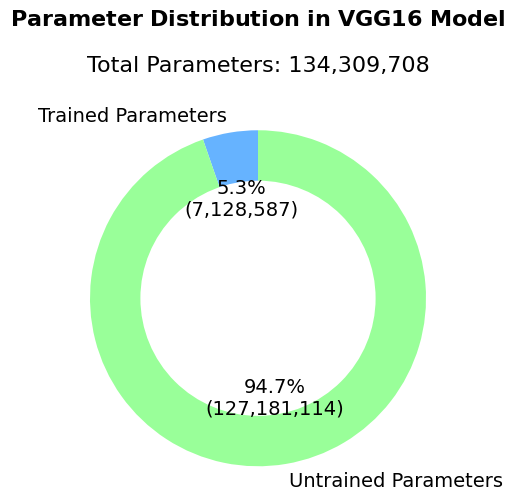

In [ ]:
# Model Complexity
summary(model_vgg16, (3, 224, 224))

total_params = sum(p.numel() for p in model_vgg16.parameters())
num_trainable_params = sum(p.numel() for p in model_vgg16.parameters() if p.requires_grad)

labels = ['Trained Parameters', 'Untrained Parameters']
sizes = [num_trainable_params, total_params - num_trainable_params]
colors = ['#66b3ff', '#99ff99']

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, labels=labels, startangle=90, colors=colors, wedgeprops=dict(width=0.4), textprops=dict(fontsize=12), autopct=lambda p: '{:.1f}%\n({:,})'.format(p, int(total_params * p / 100)))
ax.axis('equal')

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

for text, autotext in zip(texts, autotexts):
    text.set(size=14)
    autotext.set(size=14)

title_text = r"$\bf{Parameter\ Distribution\ in\ VGG16\ Model}$" + f"\n\nTotal Parameters: {total_params:,}"
plt.title(title_text, fontsize=16, pad=30)
plt.show()

In [ ]:
# Add Weighted Classes
anomaly_classes = train_metadata_VGG["anomaly_class"]

# Compute class weights using sklearn's compute_class_weight
classes_vgg16 = np.array(classes_c)
#classes=range(num_classes) -> Try running with this instead
class_weights_computed = compute_class_weight('balanced', classes = classes_vgg16, y = anomaly_classes)

class_weights = torch.tensor(class_weights_computed, dtype=torch.float32)

# Define Loss Function and Optimizer

# Define the loss function
vgg16_loss_fn = nn.CrossEntropyLoss(weight = class_weights).to(device)

# Define the optimizer
vgg16_optimizer = Adam(model_vgg16.parameters(), lr=0.001)
vgg16_scheduler = lr_scheduler.LinearLR(vgg16_optimizer, start_factor = 1.0, end_factor = 0.3, total_iters = len(trainloader_resize_and_RGB) * 10)

In [ ]:
#Taining Phase

print('Train Phase for Model VGG16:')

model_vgg16 = model_vgg16.to(device)

folder_path_vgg16 = "/content/model_vgg16"
path_model_vgg16 = "/content/model_vgg16/vgg16_model.pth"

if not os.path.exists(folder_path_vgg16):
  os.makedirs(folder_path_vgg16)

best_loss_vgg16, best_accuracy_sample_vgg16, best_accuracy_class_vgg16, best_epoch_vgg16 = train(model=model_vgg16,
                                                                                        dataloader=trainloader_resize_and_RGB,
                                                                                        loss_fn=vgg16_loss_fn,
                                                                                        optimizer=vgg16_optimizer,
                                                                                        scheduler = vgg16_scheduler,
                                                                                        device=device,
                                                                                        path_model=path_model_vgg16,
                                                                                        num_epochs=40,
                                                                                        verbatim=True)

print("Finished Training")

Train Phase for Model VGG16:

Epoch: 0 	Training Loss: 2.0019
		Training Accuracy (Sample): 35.79%
		Training Accuracy (Class): 29.09%
		Training F1-score (Weighted): 40.32%

Epoch: 1 	Training Loss: 1.5913
		Training Accuracy (Sample): 38.55%
		Training Accuracy (Class): 42.63%
		Training F1-score (Weighted): 43.82%

Epoch: 2 	Training Loss: 1.3327
		Training Accuracy (Sample): 49.77%
		Training Accuracy (Class): 52.40%
		Training F1-score (Weighted): 54.57%

Epoch: 3 	Training Loss: 1.1564
		Training Accuracy (Sample): 55.73%
		Training Accuracy (Class): 59.81%
		Training F1-score (Weighted): 59.71%

Epoch: 4 	Training Loss: 1.0033
		Training Accuracy (Sample): 60.20%
		Training Accuracy (Class): 65.52%
		Training F1-score (Weighted): 63.66%

Epoch: 5 	Training Loss: 0.8746
		Training Accuracy (Sample): 62.73%
		Training Accuracy (Class): 69.02%
		Training F1-score (Weighted): 65.83%

Epoch: 6 	Training Loss: 0.7799
		Training Accuracy (Sample): 66.06%
		Training Accuracy (Class): 72

<ipython-input-10-b11644e1a580>:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Finished Training


Loss = 3.1110 | Accuracy (Sample) = 78.70% | Accuracy (Class) = 62.01% | F1-score (Weighted) = 78.29%


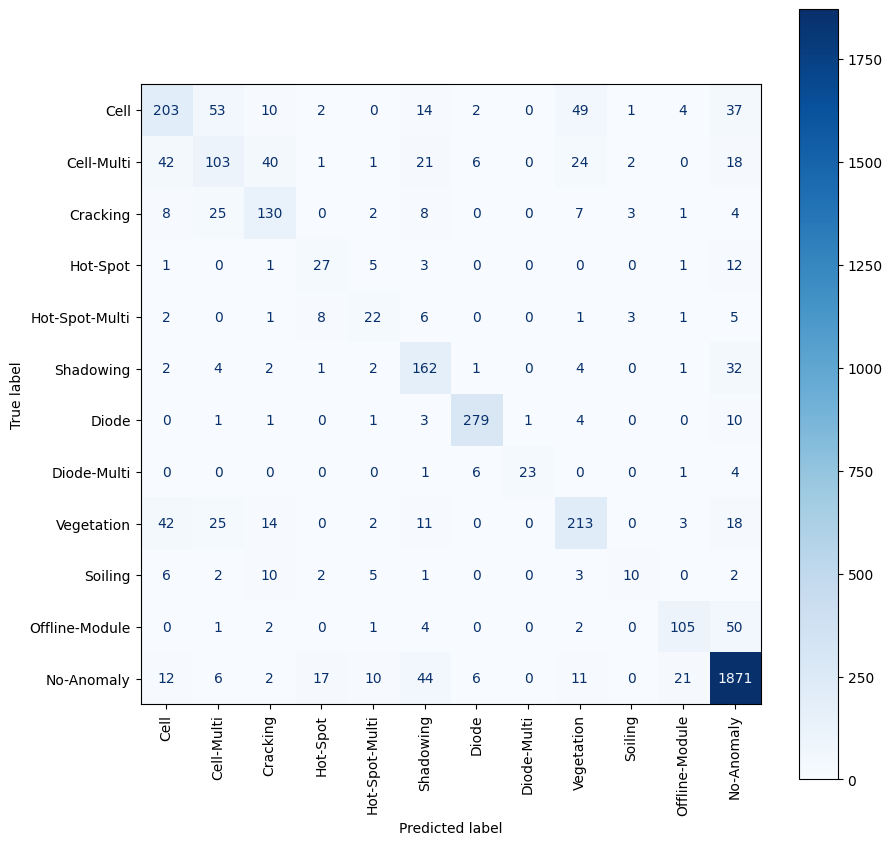

In [ ]:
#Testing Phase


y_pred_vgg16, test_loss_vgg16, test_acc_sample_vgg16, test_acc_class_vgg16, test_f1_vgg16 = test(model=model_vgg16,
                                                                            dataloader=testloader_resize_and_RGB,
                                                                            loss_fn=vgg16_loss_fn,
                                                                            device=device,
                                                                            verbatim=True)

images_vgg16, labels_vgg16, probs_vgg16, pred_labels_vgg16 = get_predictions(model_vgg16, testloader_resize_and_RGB, device, binary_classification=False)

plot_confusion_matrix(labels_vgg16, pred_labels_vgg16, 'VGG16')


#**Comparação dos resultados VGG16**

<table>
  <tr>
    <th>Model</th>
    <th>Loss</th>
    <th>Accuracy (Sample)</th>
    <th>Accuracy (Class)</th>
    <th>F1-Score (Weighted)</th>
  </tr>
  <tr>
    <td>AI Model</td>
    <td>1.3562</td>
    <td>81.73%</td>
    <td>67.35%</td>
    <td>81.37%</td>
  </tr>
  <tr>
    <td>VGG16</td>
    <td>3.1110</td>
    <td>78.70%</td>
    <td>62.01%</td>
    <td>78.29%</td>
  </tr>
</table>

Como é possível verificar pelos resultados da tabela, tanto no AI Model como no modelo VGG16, os valores das diferentes precisões mantêm-se praticamente semelhantes. As ligeiras diferenças apresentadas devem-se ao facto de o modelo VGG16 ser consideravelmente mais complexo que o AI Model, ainda que tenha apenas uma pequena margem de parâmetros treinados.

#**4) Discussion of results with the provided paper**

#**Conteúdo do Artigo:**

* O conjunto de dados inclui 20000 imagens, classificadas em 11 tipos distintos de falhas (anomalias) e uma classe sem anomalias.

* De modo a melhorar a capacidade do modelo para distinguir entre diferentes tipos de falhas, aplicaram-se técnicas de pré-processamento, mais propriamente máscaras de nitidez para melhorar a clareza das bordas das imagens.  

* De forma a resolver o desequilíbrio no conjunto de dados, foram aplicadas técnicas de sobreamostragem, gerando imagens através de operações como a inversão horizontal e vertical, ajustes de brilho e rotações. Este aumento resultou num conjunto de dados equilibrado, duplicando o número total de imagens e melhorando a capacidade de generalização do modelo.

*   O modelo Vision Transformer foi personalizado para a deteção de falhas em módulos PV. Para melhorar a extração de características em múltiplas escalas, foram integradas camadas adicionais de transformadores paralelos. O mecanismo de atenção própria permitiu ao modelo analisar características locais e globais nas imagens, identificando dependências de longo alcance crucias para a classificação de falhas. O modelo foi pré-treinado em grandes conjuntos de dados e posteriormente ajustado através da utilização do conjunto de dados termográfico, aplicando técnicas como ajuste da taxa de aprendizagem e paragem antecipada com o objetivo de otimizar o desempenho e evitar sobreajustamento.


#**Avaliação do Modelo do Artigo:**

* Com o intuito de avaliar o desempenho do modelo foram utilizadas métricas como precisão, revocação, F1-score e matrizes de confusão, evidenciando a eficácia do modelo na deteção de falhas.

  1. Classificação Binária (Anomalia e Sem Anomalia): 98,23% de precisão;

  2. Classificação Multiclasse (11 Tipos de Falhas): 96,19% de precisão;

  3. Classificação Multiclasse Expandida (11 Tipos de Falhas + Sem Anomalia): 95,55% de precisão.

* O modelo proposto foi comparado com diferentes arquiteturas conhecidas de aprendizagem profunda, incluindo ResNet50, Xception, EfficientNetB0 e VGG16, superando estas abordagens consistentemente.


#**Análise do Modelo do Artigo:**

* O modelo ViT proposto demonstrou uma precisão, revocação e F1-score superiores na deteção e classificação de falhas em módulos PV.

* Vantagens: As técnicas de aumento de dados resolveram o problema do desequilíbrio no conjunto de dados, permitindo uma generalização robusta. A arquitetura proposta demonstrou flexibilidade na classificação de tipos de falhas complexos e diversos.

* Desvantagens: A complexidade do modelo, decorrente da arquitetura baseada em transformadores, exige recursos computacionais elevados. A dependência de imagens termográficas de alta resolução pode limitar a aplicação em ambientes com recursos limitados.

#**Conteúdo do Modelo Desenvolvido:**

* O conjunto de dados inclui 20000 imagens, classificadas em 11 tipos distintos de falhas (anomalias) e uma classe sem anomalias.

* Para resolver o desequilíbrio do conjunto de dados, foram aplicadas técnicas de sobreamostragem.

* O modelo foi implementado em PyTorch e executado no Google Colaboratory.



#**Avaliação do Modelo Desenvolvido:**

<table>
  <tr>
    <th>Model</th>
    <th>Loss</th>
    <th>Accuracy (Sample)</th>
    <th>Accuracy (Class)</th>
    <th>F1-Score (Weighted)</th>
  </tr>
  <tr>
    <td>Model A</td>
    <td>0.0740</td>
    <td>93.88%</td>
    <td>93.88%</td>
    <td>93.87%</td>
  </tr>
  <tr>
    <td>Model B</td>
    <td>2.0076</td>
    <td>72.95%</td>
    <td>69.22%</td>
    <td>72.87%</td>
  </tr>
  <tr>
    <td>Model C</td>
    <td>1.3562</td>
    <td>81.73%</td>
    <td>67.35%</td>
    <td>81.37%</td>
  </tr>
</table>



* O modelo A corresponde ao modelo de duas classes, Anomalia e Sem Anomalia. Apresenta uma precisão de 93,88%.

* O modelo B corresponde ao modelo de onze classes, considerando apenas as anómalas. Apresenta uma precisão de 72,95%.

* O modelo C corresponde ao modelo de doze classes, considerando as classes anómalas e a classe Sem Anomalia. Apresenta uma precisão de 81,73%.


#**Análise do Modelo Desenvolvido:**

* Vantagens: A técnica de aumento de dados desenvolvida, permitiu que o modelo pudesse experenciar mais situações dentro de cada tipo de classificação, aumentando a sua robustez e tornando-o mais ágil para a classificação de uma nova imagem de um PV.

* Desvantagens: A arquitetura utilizada demonstra uma capacidade de classificação aceitável, podendo esta ser sujeita a melhorias com o objetivo de aumentar as suas percentagens de percisão.

#**Comparação entre os Modelos:**

Para o nosso modelo, optamos por implementar uma arquitetura projetada com quatro blocos convolucionais seguidos de uma camada adaptativa de pooling e uma secção totalmente conectada. O objetivo desta estrutura foi maximizar a extração de características relevantes, mantendo a robustez e eficiência durante o treino e o teste. Também aumentamos o conjunto de dados para garantir quantidades semelhantes de imagens por classe e equilibramos o modelo considerando pesos específicos para as classes.

As imagens utilizadas têm dimensões de 40 x 24 x 1 píxeis, sendo monocromáticas. Contudo, devido às especificações dos modelos VGG16, foi necessário redimensioná-las e convertê-las para 3 canais. Aplicámos técnicas de aumento de dados (data augmentation), que se mostraram eficazes na redução do overfitting.

Comparando o modelo do artigo com o modelo VGG16 desenvolvido, o modelo do artigo obteve uma precisão de 89.17% enquanto o nosso modelo VGG16 obteve uma precisão de 78.70%.

Analisando o artigo, o modelo de CNN desenvolvido pelos autores obteve 95.99%, um resultado superior ao nosso de 81.73%. No entanto, existem formas de melhorar o nosso modelo. Uma possibilidade seria alterar a ordem das camadas de MaxPool e BatchNorm. Além disso, a utilização de regularização nas camadas convolucionais poderia ajudar a reduzir o overfitting. Contudo, os longos tempos de execução representaram uma dificuldade que desacelerou o progresso.